In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from nilearn.decoding import Decoder
from nilearn.image import load_img
from sklearn.model_selection import LeaveOneGroupOut

In [ ]:
BIDS_ROOT = Path(r"C:/Users/duart/Desktop/Tese/Mapping_Tese/mapping_tese/data/BIDS-somatosensory/BIDS-somatosensory")
DERIVATIVES = BIDS_ROOT / "derivatives" / "fmriprep"


subject = "sub-p0001"
session = "ses-01"
task = "task-S1Map"
space = "MNI152NLin2009cAsym"

n_runs = 4
TR = 6.0

### Event files all runs

In [5]:
all_events = []
for run in range(1, n_runs + 1):
    events_path = BIDS_ROOT / subject / session / "func" / f"{subject}_{session}_{task}_run-{run}_events.tsv"
    events = pd.read_csv(events_path, sep='\t')
    events['run'] = run
    all_events.append(events)

events_df = pd.concat(all_events, ignore_index=True)

# remove Baseline and Jitter
stim_events = events_df[~events_df['trial_type'].isin(['Baseline', 'Jitter'])].copy()

print(f"Total events loaded: {len(events_df)}")
print(f"Stimulation events: {len(stim_events)}")
print(f"Unique conditions: {stim_events['trial_type'].nunique()}")
print(f"\nConditions: {sorted(stim_events['trial_type'].unique())}")
print(f"\nSamples per condition:")
print(stim_events['trial_type'].value_counts().sort_index())

Total events loaded: 328
Stimulation events: 160
Unique conditions: 20

Conditions: ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']

Samples per condition:
trial_type
E1     8
E10    8
E11    8
E12    8
E13    8
E14    8
E15    8
E16    8
E17    8
E18    8
E19    8
E2     8
E20    8
E3     8
E4     8
E5     8
E6     8
E7     8
E8     8
E9     8
Name: count, dtype: int64


In [6]:
from nilearn.image import concat_imgs

# Load preprocessed func data from runs
fmri_imgs = []
for run in range(1, n_runs + 1):
    func_path = (DERIVATIVES / subject / session / "func" / 
                 f"{subject}_{session}_{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz")
    img = load_img(str(func_path))
    fmri_imgs.append(img)
    print(f"Run {run}: {img.shape}")

# all runs together
fmri_img = concat_imgs(fmri_imgs)
print(f"\nConcatenated fMRI shape: {fmri_img.shape}")

Run 1: (121, 144, 121, 250)
Run 2: (121, 144, 121, 250)
Run 3: (121, 144, 121, 250)
Run 4: (121, 144, 121, 250)

Concatenated fMRI shape: (121, 144, 121, 1000)


In [7]:
# brain mask from first run -> all the same in MNI space
mask_path = (DERIVATIVES / subject / session / "func" / 
             f"{subject}_{session}_{task}_run-1_space-{space}_desc-brain_mask.nii.gz")
mask_img = load_img(str(mask_path))

print(f"Mask shape: {mask_img.shape}")
print(f"Mask loaded: {mask_path.name}")

Mask shape: (121, 144, 121)
Mask loaded: sub-p0001_ses-01_task-S1Map_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [ ]:
# labels for each volume in the concatenated fMRI data
# peak HRF response (~6s after stimulus onset)

labels = []
groups = []

volume_counter = 0

for run in range(1, n_runs + 1):
    run_events = stim_events[stim_events['run'] == run].copy()
    run_length = fmri_imgs[run-1].shape[3] 
    
    for _, event in run_events.iterrows():
        onset_volume = int(event['onset'] / TR)
        peak_volume = onset_volume
        if peak_volume < run_length:
            labels.append(event['trial_type'])
            groups.append(run)
    volume_counter += run_length

y = np.array(labels)
groups = np.array(groups)

print(f"Total samples: {len(y)}")
print(f"Unique labels: {len(np.unique(y))}")
print(f"Labels: {np.unique(y)}")
print(f"Groups (runs): {np.unique(groups)}")
print(f"\nSamples per run:")
for run in np.unique(groups):
    print(f"  Run {run}: {np.sum(groups == run)} samples")

Total samples: 160
Unique labels: 20
Labels: ['E1' 'E10' 'E11' 'E12' 'E13' 'E14' 'E15' 'E16' 'E17' 'E18' 'E19' 'E2'
 'E20' 'E3' 'E4' 'E5' 'E6' 'E7' 'E8' 'E9']
Groups (runs): [1 2 3 4]

Samples per run:
  Run 1: 40 samples
  Run 2: 40 samples
  Run 3: 40 samples
  Run 4: 40 samples


In [ ]:
from nilearn.image import index_img

volume_indices = []
cumulative_volumes = 0

for run in range(1, n_runs + 1):
    run_events = stim_events[stim_events['run'] == run].copy()
    run_length = fmri_imgs[run-1].shape[3]
    
    for _, event in run_events.iterrows():
        onset_volume = int(event['onset'] / TR)
        peak_volume = onset_volume
        if peak_volume < run_length:
            volume_indices.append(cumulative_volumes + peak_volume)
    
    cumulative_volumes += run_length

# relevant volumes
fmri_img_selected = index_img(fmri_img, volume_indices)

print(f"Selected volumes shape: {fmri_img_selected.shape}")
print(f"Number of samples: {len(volume_indices)}")
print(f"Matches labels: {len(volume_indices) == len(y)}")

Selected volumes shape: (121, 144, 121, 160)
Number of samples: 160
Matches labels: True


In [10]:
#cross-validation
cv = LeaveOneGroupOut()

print(f"Cross-validation: Leave-One-Group-Out")
print(f"Number of folds: {cv.get_n_splits(groups=groups)}")
print(f"Each fold leaves out one run")

Cross-validation: Leave-One-Group-Out
Number of folds: 4
Each fold leaves out one run


In [12]:
decoder = Decoder(
    estimator='svc',           
    mask=mask_img,             
    standardize='zscore_sample',  
    screening_percentile=20,   
    cv=cv,                     
    n_jobs=1               
)

decoder.fit(fmri_img_selected, y, groups=groups)

C:\Users\duart\AppData\Local\Temp\ipykernel_21868\622466374.py:10: UserWarning: screening_percentile set to '100' despite requesting 'screening_percentile=20'. 
All elements in the mask will be included. 
This usually occurs when the mask image is too small compared to full brain mask.
  decoder.fit(fmri_img_selected, y, groups=groups)
c:\Users\duart\miniconda3\envs\somatosensory_mapping\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [  167   198   390   494   587   637   649   674   713   743   865   897
   957  1087  1268  1305  1311  1537  1567  1712  1720  1939  2107  2192
  2278  2375  2473  2592  2613  2635  2646  2658  3254  3325  3363  3387
  3540  3774  3874  3903  4051  4170  4274  4430  4506  4532  4573  4602
  4618  4713  4726  4772  4987  5116  5201  5354  5401  5437  5504  5532
  5545  5557  5588  5596  5750  5915  5932  6070  6146  6178  6223  6295
  6366  6434  6456  6473  6679  6782  7029  7079  7112  7128  7144  7703
  

,estimator,'svc'
,mask,<nibabel.nift...002C0FF231150>
,cv,LeaveOneGroupOut()
,param_grid,None
,screening_percentile,20
,scoring,'roc_auc'
,smoothing_fwhm,None
,standardize,'zscore_sample'
,target_affine,None
,target_shape,None
,mask_strategy,'background'


In [16]:
# Get cross-validation scores
cv_scores = decoder.cv_scores_

# Calculate statistics
n_conditions = len(np.unique(y))

print("=" * 70)
print("DECODING RESULTS")
print("=" * 70)
print(f"\nAccuracy per fold:")
for fold, (condition, scores) in enumerate(cv_scores.items(), 1):
    print(f"  Fold {fold}: {np.mean(scores):.3f}")

all_scores = np.concatenate([scores for scores in cv_scores.values()])
mean_accuracy = np.mean(all_scores)
std_accuracy = np.std(all_scores)

print(f"\n{'=' * 70}")
print(f"Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")

print(f"Performance:   {mean_accuracy*100:.1f}%")
print(f"{'=' * 70}")

DECODING RESULTS

Accuracy per fold:
  Fold 1: 0.487
  Fold 2: 0.372
  Fold 3: 0.595
  Fold 4: 0.487
  Fold 5: 0.602
  Fold 6: 0.513
  Fold 7: 0.414
  Fold 8: 0.322
  Fold 9: 0.405
  Fold 10: 0.609
  Fold 11: 0.359
  Fold 12: 0.418
  Fold 13: 0.661
  Fold 14: 0.253
  Fold 15: 0.661
  Fold 16: 0.507
  Fold 17: 0.539
  Fold 18: 0.688
  Fold 19: 0.533
  Fold 20: 0.444

Mean Accuracy: 0.493 ± 0.224
Performance:   49.3%


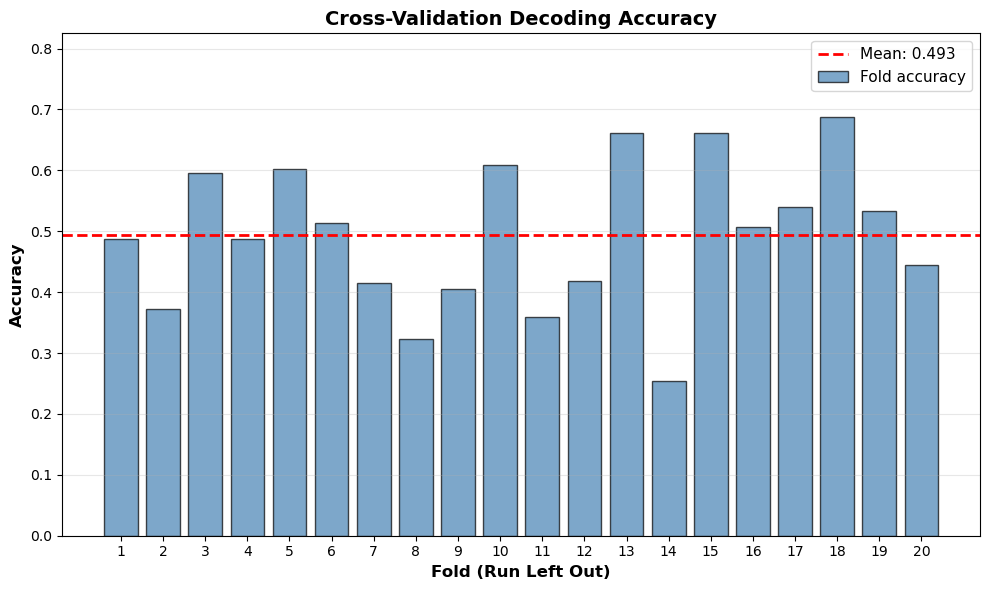

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

fold_scores = [np.mean(scores) for scores in cv_scores.values()]
folds = range(1, len(fold_scores) + 1)

ax.bar(folds, fold_scores, color='steelblue', alpha=0.7, edgecolor='black', label='Fold accuracy')
ax.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')

ax.set_xlabel('Fold (Run Left Out)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Decoding Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(folds)
ax.set_ylim([0, max(fold_scores) * 1.2])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

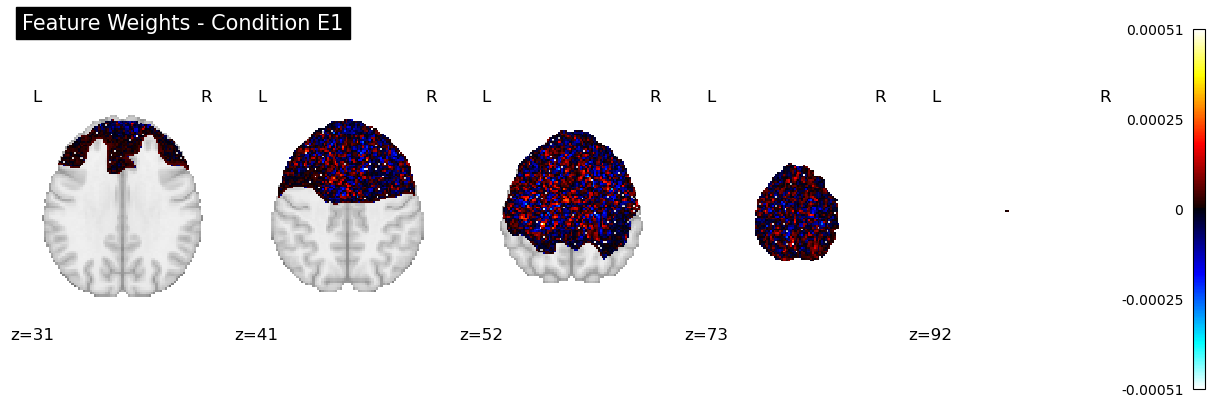

In [19]:
from nilearn import plotting

coef_img = decoder.coef_img_['E1'] 
weight_imgs = [decoder.coef_img_[condition] for condition in np.unique(y)]
fig = plt.figure(figsize=(12, 4))
plotting.plot_stat_map(
    coef_img,
    title=f'Feature Weights - Condition E1',
    cut_coords=5,
    display_mode='z',
    cmap='cold_hot',
    figure=fig
)

plt.show()